In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [7]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_pred = tf.argmax(input=actions_logits, axis=1, output_type=actions.dtype)
    mask_notequal = tf.not_equal(x=actions_pred, y=actions)
    gQs_notequal = tf.boolean_mask(mask=mask_notequal, tensor=gQs)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                    labels=tf.zeros_like(gQs_notequal))) # 0-1
    mask_equal = tf.equal(x=actions_pred, y=actions)
    gQs_equal = tf.boolean_mask(mask=mask_equal, tensor=gQs)
    rates_equal = tf.boolean_mask(mask=mask_equal, tensor=rates)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
                                                                    labels=rates_equal)) # 0-1
    targetQs_equal = tf.boolean_mask(mask=mask_equal, tensor=targetQs)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs_equal))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ, gQs_notequal, gQs_equal

In [8]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ, self.gQs_notequal, self.gQs_equal = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [10]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [11]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [12]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [13]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

/home/arasdar/miniconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _, glossQ, dlossQ = sess.run([model.d_loss, model.d_opt, 
                                                 model.g_lossQ, model.d_lossQ],
                                                feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.rates: rates})
            gloss, _, gQs_notequal, gQs_equal = sess.run([model.g_loss, model.g_opt, 
                                                          model.gQs_notequal, model.gQs_equal], 
                                              feed_dict = {model.states: states, 
                                                           model.actions: actions,
                                                           model.targetQs: targetQs, 
                                                           model.rates: rates})
            #if len(gQs_nonequal) != len(nextQs):
            # if dloss is np.nan:            
            #     print(gQs_notequal.shape, gQs_notequal.dtype)
            #     print(gQs_equal.shape, gQs_equal.dtype)
            #     print(nextQs.shape)
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0000 rate:0.0400 gloss:1.3658 dloss:3.3594 glossQ:1.0115 dlossQ:2.0535 exploreP:0.9980
Episode:1 meanR:20.0000 R:20.0000 rate:0.0400 gloss:1.3563 dloss:3.3135 glossQ:1.0158 dlossQ:1.9853 exploreP:0.9960
Episode:2 meanR:26.0000 R:38.0000 rate:0.0760 gloss:1.3543 dloss:3.3019 glossQ:1.0185 dlossQ:1.9371 exploreP:0.9923
Episode:3 meanR:22.7500 R:13.0000 rate:0.0260 gloss:1.3555 dloss:3.3021 glossQ:1.0214 dlossQ:1.8638 exploreP:0.9910
Episode:4 meanR:24.4000 R:31.0000 rate:0.0620 gloss:1.3494 dloss:3.2715 glossQ:1.0246 dlossQ:1.8273 exploreP:0.9880
Episode:5 meanR:24.6667 R:26.0000 rate:0.0520 gloss:1.3419 dloss:3.2374 glossQ:1.0301 dlossQ:1.8033 exploreP:0.9855
Episode:6 meanR:22.8571 R:12.0000 rate:0.0240 gloss:1.3397 dloss:3.2219 glossQ:1.0323 dlossQ:1.7295 exploreP:0.9843
Episode:7 meanR:22.3750 R:19.0000 rate:0.0380 gloss:1.3410 dloss:3.2293 glossQ:1.0330 dlossQ:1.7776 exploreP:0.9824
Episode:8 meanR:23.8889 R:36.0000 rate:0.0720 gloss:1.3325 dloss:3.1920 

Episode:71 meanR:20.8056 R:49.0000 rate:0.0980 gloss:1.2835 dloss:2.9441 glossQ:1.0578 dlossQ:1.3538 exploreP:0.8623
Episode:72 meanR:20.6849 R:12.0000 rate:0.0240 gloss:1.2885 dloss:2.9327 glossQ:1.0600 dlossQ:1.2912 exploreP:0.8612
Episode:73 meanR:20.7297 R:24.0000 rate:0.0480 gloss:1.2860 dloss:2.9307 glossQ:1.0566 dlossQ:1.2781 exploreP:0.8592
Episode:74 meanR:20.6933 R:18.0000 rate:0.0360 gloss:1.2765 dloss:2.9009 glossQ:1.0672 dlossQ:1.2568 exploreP:0.8577
Episode:75 meanR:20.8684 R:34.0000 rate:0.0680 gloss:1.2721 dloss:2.8791 glossQ:1.0701 dlossQ:1.1665 exploreP:0.8548
Episode:76 meanR:20.9091 R:24.0000 rate:0.0480 gloss:1.2710 dloss:2.8511 glossQ:1.0724 dlossQ:1.1092 exploreP:0.8528
Episode:77 meanR:20.7821 R:11.0000 rate:0.0220 gloss:1.2732 dloss:2.8509 glossQ:1.0803 dlossQ:1.0376 exploreP:0.8519
Episode:78 meanR:20.7722 R:20.0000 rate:0.0400 gloss:1.2534 dloss:2.8039 glossQ:1.0787 dlossQ:1.0132 exploreP:0.8502
Episode:79 meanR:20.8000 R:23.0000 rate:0.0460 gloss:1.2505 dlos

Episode:141 meanR:19.4300 R:12.0000 rate:0.0240 gloss:1.1464 dloss:2.4245 glossQ:1.1493 dlossQ:0.6687 exploreP:0.7555
Episode:142 meanR:19.2900 R:12.0000 rate:0.0240 gloss:1.1764 dloss:2.4793 glossQ:1.1219 dlossQ:0.6552 exploreP:0.7546
Episode:143 meanR:19.2900 R:11.0000 rate:0.0220 gloss:1.1928 dloss:2.5162 glossQ:1.1254 dlossQ:0.6587 exploreP:0.7538
Episode:144 meanR:19.2300 R:15.0000 rate:0.0300 gloss:1.1855 dloss:2.5046 glossQ:1.1254 dlossQ:0.6618 exploreP:0.7527
Episode:145 meanR:19.1700 R:13.0000 rate:0.0260 gloss:1.1617 dloss:2.4656 glossQ:1.1362 dlossQ:0.6624 exploreP:0.7517
Episode:146 meanR:19.2300 R:24.0000 rate:0.0480 gloss:1.1750 dloss:2.4834 glossQ:1.1492 dlossQ:0.6889 exploreP:0.7500
Episode:147 meanR:19.3800 R:26.0000 rate:0.0520 gloss:1.1803 dloss:2.4989 glossQ:1.1244 dlossQ:0.6787 exploreP:0.7480
Episode:148 meanR:19.3100 R:19.0000 rate:0.0380 gloss:1.1785 dloss:nan glossQ:1.1683 dlossQ:0.6918 exploreP:0.7466
Episode:149 meanR:19.3600 R:15.0000 rate:0.0300 gloss:1.166

Episode:211 meanR:17.3300 R:19.0000 rate:0.0380 gloss:1.2105 dloss:2.6869 glossQ:1.1018 dlossQ:0.9689 exploreP:0.6722
Episode:212 meanR:17.3900 R:19.0000 rate:0.0380 gloss:1.2265 dloss:2.7206 glossQ:1.0883 dlossQ:0.9661 exploreP:0.6710
Episode:213 meanR:17.4800 R:19.0000 rate:0.0380 gloss:1.2346 dloss:2.7401 glossQ:1.0872 dlossQ:0.9816 exploreP:0.6697
Episode:214 meanR:17.6300 R:27.0000 rate:0.0540 gloss:1.2159 dloss:2.7071 glossQ:1.0958 dlossQ:1.0054 exploreP:0.6679
Episode:215 meanR:17.7600 R:21.0000 rate:0.0420 gloss:1.2311 dloss:2.7401 glossQ:1.0891 dlossQ:1.0312 exploreP:0.6666
Episode:216 meanR:17.7100 R:10.0000 rate:0.0200 gloss:1.2224 dloss:2.7295 glossQ:1.0894 dlossQ:1.0464 exploreP:0.6659
Episode:217 meanR:17.7100 R:13.0000 rate:0.0260 gloss:1.2243 dloss:2.7304 glossQ:1.0872 dlossQ:1.0481 exploreP:0.6650
Episode:218 meanR:17.6300 R:9.0000 rate:0.0180 gloss:1.2455 dloss:2.7779 glossQ:1.0803 dlossQ:1.0539 exploreP:0.6645
Episode:219 meanR:17.5900 R:11.0000 rate:0.0220 gloss:1.2

Episode:281 meanR:16.3400 R:19.0000 rate:0.0380 gloss:1.1931 dloss:2.6129 glossQ:1.1058 dlossQ:0.7685 exploreP:0.6048
Episode:282 meanR:16.3600 R:15.0000 rate:0.0300 gloss:1.1964 dloss:2.6203 glossQ:1.1138 dlossQ:0.7608 exploreP:0.6040
Episode:283 meanR:16.2700 R:11.0000 rate:0.0220 gloss:1.1933 dloss:2.6031 glossQ:1.0892 dlossQ:0.7160 exploreP:0.6033
Episode:284 meanR:16.3000 R:14.0000 rate:0.0280 gloss:1.1975 dloss:2.6139 glossQ:1.1088 dlossQ:0.7457 exploreP:0.6025
Episode:285 meanR:16.1700 R:12.0000 rate:0.0240 gloss:1.1819 dloss:2.5821 glossQ:1.1084 dlossQ:0.7420 exploreP:0.6018
Episode:286 meanR:16.2300 R:17.0000 rate:0.0340 gloss:1.1905 dloss:2.5982 glossQ:1.1120 dlossQ:0.7566 exploreP:0.6008
Episode:287 meanR:16.2900 R:15.0000 rate:0.0300 gloss:1.1883 dloss:2.5972 glossQ:1.1085 dlossQ:0.7559 exploreP:0.5999
Episode:288 meanR:16.3000 R:13.0000 rate:0.0260 gloss:1.1695 dloss:2.5531 glossQ:1.1065 dlossQ:0.7233 exploreP:0.5991
Episode:289 meanR:16.3000 R:10.0000 rate:0.0200 gloss:1.

Episode:351 meanR:14.9000 R:10.0000 rate:0.0200 gloss:1.1834 dloss:2.5804 glossQ:1.1083 dlossQ:0.8186 exploreP:0.5478
Episode:352 meanR:14.8200 R:12.0000 rate:0.0240 gloss:1.2203 dloss:2.6522 glossQ:1.0848 dlossQ:0.8105 exploreP:0.5472
Episode:353 meanR:14.7700 R:12.0000 rate:0.0240 gloss:1.1943 dloss:2.6050 glossQ:1.0986 dlossQ:0.8217 exploreP:0.5465
Episode:354 meanR:14.9300 R:29.0000 rate:0.0580 gloss:1.2016 dloss:2.6172 glossQ:1.1002 dlossQ:0.8161 exploreP:0.5450
Episode:355 meanR:14.8600 R:9.0000 rate:0.0180 gloss:1.1962 dloss:2.6052 glossQ:1.1063 dlossQ:0.8397 exploreP:0.5445
Episode:356 meanR:14.8500 R:11.0000 rate:0.0220 gloss:1.1960 dloss:2.6124 glossQ:1.1012 dlossQ:0.8028 exploreP:0.5439
Episode:357 meanR:14.8700 R:14.0000 rate:0.0280 gloss:1.2089 dloss:2.6335 glossQ:1.0981 dlossQ:0.8219 exploreP:0.5432
Episode:358 meanR:14.8200 R:12.0000 rate:0.0240 gloss:1.2101 dloss:2.6383 glossQ:1.1004 dlossQ:0.8330 exploreP:0.5425
Episode:359 meanR:14.8600 R:20.0000 rate:0.0400 gloss:1.2

Episode:421 meanR:14.0800 R:11.0000 rate:0.0220 gloss:1.1970 dloss:2.5945 glossQ:1.1034 dlossQ:0.8010 exploreP:0.4980
Episode:422 meanR:14.2000 R:21.0000 rate:0.0420 gloss:1.2053 dloss:2.6188 glossQ:1.1021 dlossQ:0.8088 exploreP:0.4970
Episode:423 meanR:14.0500 R:11.0000 rate:0.0220 gloss:1.1761 dloss:2.5633 glossQ:1.1137 dlossQ:0.8210 exploreP:0.4964
Episode:424 meanR:14.0300 R:17.0000 rate:0.0340 gloss:1.1953 dloss:2.5961 glossQ:1.1008 dlossQ:0.8005 exploreP:0.4956
Episode:425 meanR:14.0000 R:11.0000 rate:0.0220 gloss:1.1996 dloss:2.5959 glossQ:1.1057 dlossQ:0.7978 exploreP:0.4951
Episode:426 meanR:13.9900 R:9.0000 rate:0.0180 gloss:1.1854 dloss:2.5762 glossQ:1.1024 dlossQ:0.7844 exploreP:0.4946
Episode:427 meanR:13.8900 R:10.0000 rate:0.0200 gloss:1.2038 dloss:2.6119 glossQ:1.1034 dlossQ:0.8141 exploreP:0.4942
Episode:428 meanR:13.7100 R:8.0000 rate:0.0160 gloss:1.1713 dloss:2.5474 glossQ:1.1312 dlossQ:0.8354 exploreP:0.4938
Episode:429 meanR:13.7400 R:12.0000 rate:0.0240 gloss:1.18

Episode:491 meanR:13.7400 R:14.0000 rate:0.0280 gloss:1.2047 dloss:2.6183 glossQ:1.0993 dlossQ:0.7757 exploreP:0.4525
Episode:492 meanR:13.7300 R:9.0000 rate:0.0180 gloss:1.1986 dloss:2.5904 glossQ:1.1072 dlossQ:0.7842 exploreP:0.4521
Episode:493 meanR:13.7800 R:15.0000 rate:0.0300 gloss:1.1883 dloss:2.5777 glossQ:1.1129 dlossQ:0.7970 exploreP:0.4515
Episode:494 meanR:13.7500 R:11.0000 rate:0.0220 gloss:1.1928 dloss:2.5820 glossQ:1.0878 dlossQ:0.7791 exploreP:0.4510
Episode:495 meanR:13.7500 R:15.0000 rate:0.0300 gloss:1.2018 dloss:2.6060 glossQ:1.1011 dlossQ:0.7902 exploreP:0.4503
Episode:496 meanR:13.6800 R:11.0000 rate:0.0220 gloss:1.1823 dloss:2.5646 glossQ:1.1246 dlossQ:0.8033 exploreP:0.4498
Episode:497 meanR:13.6400 R:9.0000 rate:0.0180 gloss:1.1617 dloss:2.5199 glossQ:1.1166 dlossQ:0.7913 exploreP:0.4494
Episode:498 meanR:13.5200 R:11.0000 rate:0.0220 gloss:1.1752 dloss:2.5522 glossQ:1.1171 dlossQ:0.7953 exploreP:0.4490
Episode:499 meanR:13.6300 R:20.0000 rate:0.0400 gloss:1.18

Episode:561 meanR:12.9900 R:13.0000 rate:0.0260 gloss:1.2256 dloss:2.7303 glossQ:1.0900 dlossQ:1.0224 exploreP:0.4142
Episode:562 meanR:12.9300 R:10.0000 rate:0.0200 gloss:1.2520 dloss:2.7907 glossQ:1.0858 dlossQ:1.0121 exploreP:0.4138
Episode:563 meanR:12.9000 R:9.0000 rate:0.0180 gloss:1.2345 dloss:2.7652 glossQ:1.0909 dlossQ:1.0390 exploreP:0.4135
Episode:564 meanR:12.8900 R:19.0000 rate:0.0380 gloss:1.2250 dloss:nan glossQ:1.0868 dlossQ:1.0066 exploreP:0.4127
Episode:565 meanR:12.7800 R:13.0000 rate:0.0260 gloss:1.2254 dloss:2.7378 glossQ:1.0898 dlossQ:1.0078 exploreP:0.4122
Episode:566 meanR:12.7800 R:11.0000 rate:0.0220 gloss:1.2306 dloss:2.7396 glossQ:1.0957 dlossQ:0.9855 exploreP:0.4117
Episode:567 meanR:12.7600 R:10.0000 rate:0.0200 gloss:1.2481 dloss:2.7910 glossQ:1.0791 dlossQ:1.0435 exploreP:0.4113
Episode:568 meanR:12.7300 R:9.0000 rate:0.0180 gloss:1.2287 dloss:2.7450 glossQ:1.0908 dlossQ:1.0260 exploreP:0.4110
Episode:569 meanR:12.6600 R:9.0000 rate:0.0180 gloss:1.2199 d

Episode:631 meanR:12.0900 R:11.0000 rate:0.0220 gloss:1.1976 dloss:2.5942 glossQ:1.2513 dlossQ:0.8889 exploreP:0.3813
Episode:632 meanR:12.0900 R:12.0000 rate:0.0240 gloss:1.2042 dloss:2.6248 glossQ:1.1064 dlossQ:0.7857 exploreP:0.3808
Episode:633 meanR:12.0300 R:8.0000 rate:0.0160 gloss:1.2056 dloss:2.6191 glossQ:1.1120 dlossQ:0.7777 exploreP:0.3805
Episode:634 meanR:12.1700 R:25.0000 rate:0.0500 gloss:1.1957 dloss:2.6029 glossQ:1.1042 dlossQ:0.7701 exploreP:0.3796
Episode:635 meanR:12.2000 R:17.0000 rate:0.0340 gloss:1.2139 dloss:2.6295 glossQ:1.0970 dlossQ:0.7655 exploreP:0.3790
Episode:636 meanR:12.1900 R:14.0000 rate:0.0280 gloss:1.2009 dloss:2.6112 glossQ:1.1092 dlossQ:0.7829 exploreP:0.3784
Episode:637 meanR:12.2100 R:11.0000 rate:0.0220 gloss:1.1965 dloss:2.6106 glossQ:1.1078 dlossQ:0.7847 exploreP:0.3780
Episode:638 meanR:12.2300 R:12.0000 rate:0.0240 gloss:1.1966 dloss:2.6064 glossQ:1.1095 dlossQ:0.7845 exploreP:0.3776
Episode:639 meanR:12.2700 R:17.0000 rate:0.0340 gloss:1.2

Episode:701 meanR:12.3300 R:8.0000 rate:0.0160 gloss:1.1986 dloss:2.6169 glossQ:1.1091 dlossQ:0.8449 exploreP:0.3514
Episode:702 meanR:12.3300 R:11.0000 rate:0.0220 gloss:1.1632 dloss:2.5279 glossQ:1.1220 dlossQ:0.8059 exploreP:0.3510
Episode:703 meanR:12.2000 R:9.0000 rate:0.0180 gloss:1.1963 dloss:2.6132 glossQ:1.1210 dlossQ:0.8848 exploreP:0.3507
Episode:704 meanR:12.1100 R:11.0000 rate:0.0220 gloss:1.2083 dloss:2.6289 glossQ:1.0946 dlossQ:0.8053 exploreP:0.3503
Episode:705 meanR:12.0600 R:10.0000 rate:0.0200 gloss:1.1675 dloss:2.5484 glossQ:1.1505 dlossQ:0.8614 exploreP:0.3500
Episode:706 meanR:12.0800 R:11.0000 rate:0.0220 gloss:1.1956 dloss:2.6163 glossQ:1.0965 dlossQ:0.8409 exploreP:0.3496
Episode:707 meanR:12.0900 R:12.0000 rate:0.0240 gloss:1.1877 dloss:2.5939 glossQ:1.0984 dlossQ:0.8194 exploreP:0.3492
Episode:708 meanR:12.1200 R:13.0000 rate:0.0260 gloss:1.2287 dloss:2.6937 glossQ:1.0930 dlossQ:0.8877 exploreP:0.3488
Episode:709 meanR:12.1600 R:16.0000 rate:0.0320 gloss:1.18

Episode:771 meanR:11.9300 R:11.0000 rate:0.0220 gloss:1.1939 dloss:2.6354 glossQ:1.1081 dlossQ:0.9267 exploreP:0.3238
Episode:772 meanR:11.9200 R:10.0000 rate:0.0200 gloss:1.2129 dloss:2.6722 glossQ:1.0968 dlossQ:0.9049 exploreP:0.3234
Episode:773 meanR:11.9000 R:11.0000 rate:0.0220 gloss:1.2009 dloss:2.6516 glossQ:1.1008 dlossQ:0.9356 exploreP:0.3231
Episode:774 meanR:11.8900 R:8.0000 rate:0.0160 gloss:1.1909 dloss:2.6268 glossQ:1.1080 dlossQ:0.9094 exploreP:0.3228
Episode:775 meanR:11.8900 R:10.0000 rate:0.0200 gloss:1.2140 dloss:2.6736 glossQ:1.1209 dlossQ:0.9446 exploreP:0.3225
Episode:776 meanR:11.8800 R:10.0000 rate:0.0200 gloss:1.2169 dloss:2.6793 glossQ:1.0966 dlossQ:0.9075 exploreP:0.3222
Episode:777 meanR:11.8500 R:11.0000 rate:0.0220 gloss:1.2208 dloss:2.6694 glossQ:1.2270 dlossQ:1.0062 exploreP:0.3219
Episode:778 meanR:11.7900 R:9.0000 rate:0.0180 gloss:1.1887 dloss:2.6239 glossQ:1.1242 dlossQ:0.9175 exploreP:0.3216
Episode:779 meanR:11.7400 R:10.0000 rate:0.0200 gloss:1.24

Episode:841 meanR:11.3400 R:12.0000 rate:0.0240 gloss:1.2071 dloss:2.6831 glossQ:1.0922 dlossQ:1.0525 exploreP:0.3010
Episode:842 meanR:11.3600 R:12.0000 rate:0.0240 gloss:1.2241 dloss:2.7105 glossQ:1.0835 dlossQ:1.0307 exploreP:0.3006
Episode:843 meanR:11.3300 R:12.0000 rate:0.0240 gloss:1.2061 dloss:2.6806 glossQ:1.1211 dlossQ:1.0757 exploreP:0.3003
Episode:844 meanR:11.3400 R:10.0000 rate:0.0200 gloss:1.2012 dloss:2.6733 glossQ:1.1323 dlossQ:1.0810 exploreP:0.3000
Episode:845 meanR:11.3100 R:9.0000 rate:0.0180 gloss:1.2431 dloss:2.7372 glossQ:1.0835 dlossQ:1.0193 exploreP:0.2997
Episode:846 meanR:11.2600 R:9.0000 rate:0.0180 gloss:1.2119 dloss:2.6896 glossQ:1.0951 dlossQ:1.0399 exploreP:0.2995
Episode:847 meanR:11.2400 R:9.0000 rate:0.0180 gloss:1.2225 dloss:2.7090 glossQ:1.0884 dlossQ:1.0262 exploreP:0.2992
Episode:848 meanR:11.2000 R:10.0000 rate:0.0200 gloss:1.2194 dloss:2.7031 glossQ:1.0882 dlossQ:1.0285 exploreP:0.2989
Episode:849 meanR:11.1900 R:10.0000 rate:0.0200 gloss:1.220

Episode:911 meanR:10.8000 R:10.0000 rate:0.0200 gloss:1.2051 dloss:2.6690 glossQ:1.1060 dlossQ:1.0298 exploreP:0.2798
Episode:912 meanR:10.7600 R:10.0000 rate:0.0200 gloss:1.1905 dloss:2.6308 glossQ:1.1149 dlossQ:1.0104 exploreP:0.2795
Episode:913 meanR:10.7600 R:12.0000 rate:0.0240 gloss:1.2050 dloss:2.6625 glossQ:1.1365 dlossQ:1.0505 exploreP:0.2792
Episode:914 meanR:10.7700 R:11.0000 rate:0.0220 gloss:1.1929 dloss:2.6409 glossQ:1.1065 dlossQ:1.0319 exploreP:0.2789
Episode:915 meanR:10.7800 R:10.0000 rate:0.0200 gloss:1.2020 dloss:2.6626 glossQ:1.1111 dlossQ:1.0497 exploreP:0.2786
Episode:916 meanR:10.7700 R:10.0000 rate:0.0200 gloss:1.2116 dloss:2.6633 glossQ:1.0901 dlossQ:0.9975 exploreP:0.2783
Episode:917 meanR:10.7600 R:10.0000 rate:0.0200 gloss:1.2009 dloss:2.6496 glossQ:1.1074 dlossQ:1.0160 exploreP:0.2781
Episode:918 meanR:10.7500 R:9.0000 rate:0.0180 gloss:1.2098 dloss:2.6721 glossQ:1.1073 dlossQ:1.0282 exploreP:0.2778
Episode:919 meanR:10.7300 R:9.0000 rate:0.0180 gloss:1.18

Episode:981 meanR:10.6100 R:9.0000 rate:0.0180 gloss:1.2163 dloss:2.6905 glossQ:1.1005 dlossQ:1.0050 exploreP:0.2604
Episode:982 meanR:10.6200 R:9.0000 rate:0.0180 gloss:1.2010 dloss:2.6520 glossQ:1.1171 dlossQ:1.0232 exploreP:0.2601
Episode:983 meanR:10.6100 R:9.0000 rate:0.0180 gloss:1.1805 dloss:2.6085 glossQ:1.1213 dlossQ:1.0183 exploreP:0.2599
Episode:984 meanR:10.6100 R:10.0000 rate:0.0200 gloss:1.2122 dloss:2.6859 glossQ:1.0892 dlossQ:1.0110 exploreP:0.2597
Episode:985 meanR:10.6200 R:11.0000 rate:0.0220 gloss:1.2106 dloss:2.6704 glossQ:1.0921 dlossQ:0.9889 exploreP:0.2594
Episode:986 meanR:10.6200 R:9.0000 rate:0.0180 gloss:1.2235 dloss:2.6928 glossQ:1.0928 dlossQ:0.9951 exploreP:0.2592
Episode:987 meanR:10.5800 R:9.0000 rate:0.0180 gloss:1.2213 dloss:2.7017 glossQ:1.1048 dlossQ:1.0253 exploreP:0.2589
Episode:988 meanR:10.5600 R:10.0000 rate:0.0200 gloss:1.1968 dloss:2.6455 glossQ:1.1012 dlossQ:0.9942 exploreP:0.2587
Episode:989 meanR:10.5900 R:14.0000 rate:0.0280 gloss:1.2152 

Episode:1051 meanR:10.6600 R:10.0000 rate:0.0200 gloss:1.1897 dloss:2.6320 glossQ:1.1206 dlossQ:0.9966 exploreP:0.2424
Episode:1052 meanR:10.6500 R:13.0000 rate:0.0260 gloss:1.2066 dloss:2.6555 glossQ:1.0963 dlossQ:0.9684 exploreP:0.2421
Episode:1053 meanR:10.6900 R:14.0000 rate:0.0280 gloss:1.2135 dloss:2.6768 glossQ:1.0978 dlossQ:0.9796 exploreP:0.2418
Episode:1054 meanR:10.6800 R:10.0000 rate:0.0200 gloss:1.2363 dloss:2.7190 glossQ:1.0877 dlossQ:0.9571 exploreP:0.2416
Episode:1055 meanR:10.7000 R:12.0000 rate:0.0240 gloss:1.2632 dloss:2.7796 glossQ:1.0718 dlossQ:0.9611 exploreP:0.2413
Episode:1056 meanR:10.6900 R:10.0000 rate:0.0200 gloss:1.1928 dloss:2.6412 glossQ:1.1108 dlossQ:0.9863 exploreP:0.2410
Episode:1057 meanR:10.7000 R:12.0000 rate:0.0240 gloss:1.1860 dloss:2.6247 glossQ:1.1145 dlossQ:0.9978 exploreP:0.2408
Episode:1058 meanR:10.6900 R:8.0000 rate:0.0160 gloss:1.2075 dloss:2.6725 glossQ:1.0980 dlossQ:1.0098 exploreP:0.2406
Episode:1059 meanR:10.6800 R:9.0000 rate:0.0180 g

Episode:1121 meanR:10.7200 R:14.0000 rate:0.0280 gloss:1.2041 dloss:2.6499 glossQ:1.0972 dlossQ:0.9419 exploreP:0.2256
Episode:1122 meanR:10.7300 R:11.0000 rate:0.0220 gloss:1.2080 dloss:2.6656 glossQ:1.0920 dlossQ:0.9677 exploreP:0.2253
Episode:1123 meanR:10.7500 R:11.0000 rate:0.0220 gloss:1.2057 dloss:2.6586 glossQ:1.0997 dlossQ:0.9450 exploreP:0.2251
Episode:1124 meanR:10.7300 R:9.0000 rate:0.0180 gloss:1.2022 dloss:2.6543 glossQ:1.1099 dlossQ:0.9807 exploreP:0.2249
Episode:1125 meanR:10.7500 R:13.0000 rate:0.0260 gloss:1.2087 dloss:2.6672 glossQ:1.0873 dlossQ:0.9613 exploreP:0.2246
Episode:1126 meanR:10.7200 R:8.0000 rate:0.0160 gloss:1.2122 dloss:2.6736 glossQ:1.0949 dlossQ:0.9422 exploreP:0.2245
Episode:1127 meanR:10.7300 R:12.0000 rate:0.0240 gloss:1.2113 dloss:2.6624 glossQ:1.0895 dlossQ:0.9383 exploreP:0.2242
Episode:1128 meanR:10.7200 R:11.0000 rate:0.0220 gloss:1.2154 dloss:2.6771 glossQ:1.1021 dlossQ:0.9402 exploreP:0.2240
Episode:1129 meanR:10.7300 R:10.0000 rate:0.0200 g

Episode:1191 meanR:10.5300 R:10.0000 rate:0.0200 gloss:1.2166 dloss:2.6743 glossQ:1.1093 dlossQ:0.9694 exploreP:0.2104
Episode:1192 meanR:10.5000 R:8.0000 rate:0.0160 gloss:1.2066 dloss:2.6468 glossQ:1.1080 dlossQ:0.9334 exploreP:0.2103
Episode:1193 meanR:10.4700 R:8.0000 rate:0.0160 gloss:1.2114 dloss:2.6686 glossQ:1.1073 dlossQ:0.9651 exploreP:0.2101
Episode:1194 meanR:10.4500 R:9.0000 rate:0.0180 gloss:1.1957 dloss:2.6372 glossQ:1.1029 dlossQ:0.9587 exploreP:0.2099
Episode:1195 meanR:10.4400 R:11.0000 rate:0.0220 gloss:1.1794 dloss:2.5969 glossQ:1.1137 dlossQ:0.9443 exploreP:0.2097
Episode:1196 meanR:10.4600 R:10.0000 rate:0.0200 gloss:1.1868 dloss:2.6127 glossQ:1.1158 dlossQ:0.9485 exploreP:0.2095
Episode:1197 meanR:10.4600 R:9.0000 rate:0.0180 gloss:1.2065 dloss:2.6443 glossQ:1.1067 dlossQ:0.9307 exploreP:0.2093
Episode:1198 meanR:10.4600 R:10.0000 rate:0.0200 gloss:1.1820 dloss:2.6064 glossQ:1.1141 dlossQ:0.9587 exploreP:0.2091
Episode:1199 meanR:10.4800 R:10.0000 rate:0.0200 glo

Episode:1261 meanR:10.4100 R:10.0000 rate:0.0200 gloss:1.1803 dloss:2.5818 glossQ:1.1134 dlossQ:0.9514 exploreP:0.1963
Episode:1262 meanR:10.4100 R:13.0000 rate:0.0260 gloss:1.1928 dloss:2.6117 glossQ:1.1046 dlossQ:0.9483 exploreP:0.1961
Episode:1263 meanR:10.3900 R:9.0000 rate:0.0180 gloss:1.1805 dloss:2.5887 glossQ:1.1138 dlossQ:0.9613 exploreP:0.1959
Episode:1264 meanR:10.4200 R:14.0000 rate:0.0280 gloss:1.1901 dloss:2.6065 glossQ:1.1083 dlossQ:0.9337 exploreP:0.1957
Episode:1265 meanR:10.4400 R:11.0000 rate:0.0220 gloss:1.2131 dloss:2.6498 glossQ:1.0927 dlossQ:0.9309 exploreP:0.1955
Episode:1266 meanR:10.3800 R:9.0000 rate:0.0180 gloss:1.2096 dloss:2.6474 glossQ:1.1120 dlossQ:0.9416 exploreP:0.1953
Episode:1267 meanR:10.3700 R:9.0000 rate:0.0180 gloss:1.1955 dloss:2.6147 glossQ:1.1162 dlossQ:0.9332 exploreP:0.1951
Episode:1268 meanR:10.3600 R:9.0000 rate:0.0180 gloss:1.2051 dloss:2.6400 glossQ:1.0886 dlossQ:0.9202 exploreP:0.1950
Episode:1269 meanR:10.3700 R:10.0000 rate:0.0200 glo

Episode:1330 meanR:14.4600 R:39.0000 rate:0.0780 gloss:1.1956 dloss:2.6107 glossQ:1.1409 dlossQ:1.0901 exploreP:0.1767
Episode:1331 meanR:14.7800 R:42.0000 rate:0.0840 gloss:1.1930 dloss:2.5960 glossQ:1.1160 dlossQ:1.0144 exploreP:0.1760
Episode:1332 meanR:15.0400 R:35.0000 rate:0.0700 gloss:1.1959 dloss:2.6058 glossQ:1.1041 dlossQ:0.9996 exploreP:0.1754
Episode:1333 meanR:15.3000 R:35.0000 rate:0.0700 gloss:1.2093 dloss:2.6363 glossQ:1.1095 dlossQ:1.0358 exploreP:0.1749
Episode:1334 meanR:15.4900 R:28.0000 rate:0.0560 gloss:1.2042 dloss:2.6300 glossQ:1.1092 dlossQ:1.0273 exploreP:0.1744
Episode:1335 meanR:15.6900 R:30.0000 rate:0.0600 gloss:1.1958 dloss:2.6117 glossQ:1.1079 dlossQ:1.0199 exploreP:0.1739
Episode:1336 meanR:17.3700 R:185.0000 rate:0.3700 gloss:1.1982 dloss:2.6163 glossQ:1.1098 dlossQ:1.0561 exploreP:0.1709
Episode:1337 meanR:19.6200 R:240.0000 rate:0.4800 gloss:1.2118 dloss:2.6473 glossQ:1.1197 dlossQ:1.0744 exploreP:0.1671
Episode:1338 meanR:22.0700 R:255.0000 rate:0.5

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

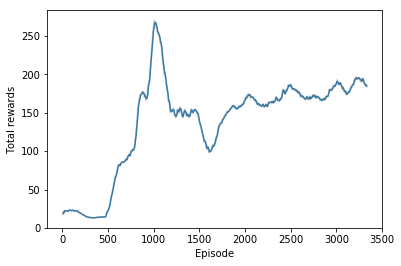

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

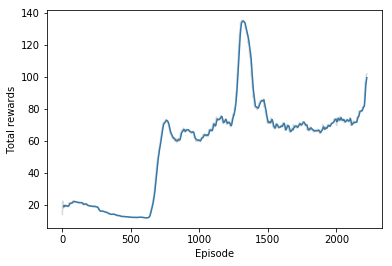

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

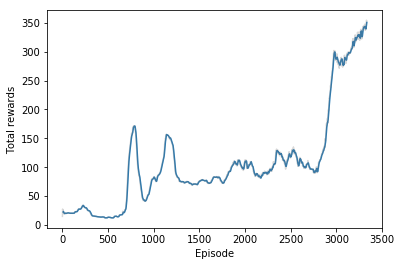

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

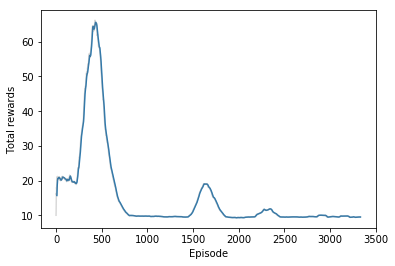

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

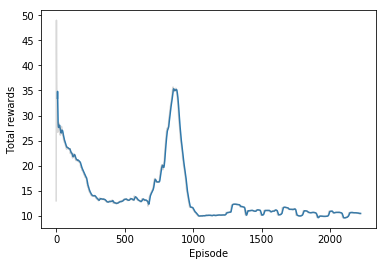

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

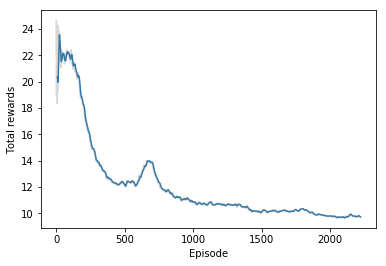

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

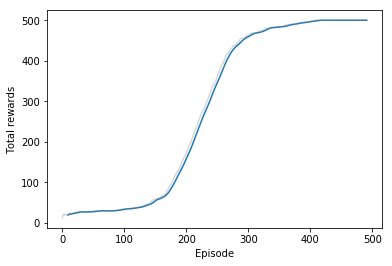

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

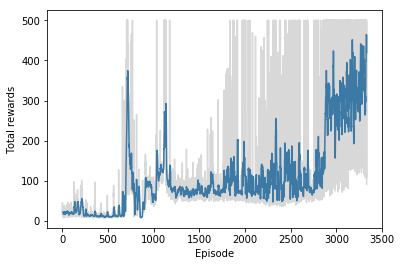

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

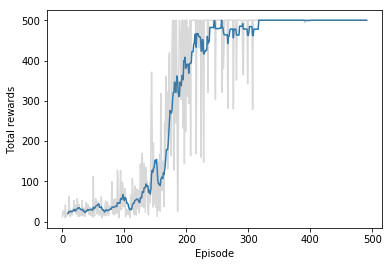

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.